# Modelling

## Packages

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import winsound
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from keras.utils import np_utils

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt

print(f" Found and Using {len(tf.config.experimental.list_physical_devices('GPU'))} GPU")

 Found and Using 1 GPU


## Functions

In [2]:
def scale_x_encode_y(x, y):

    x_scaled = StandardScaler().fit_transform(x.values)    
    
    encoder = LabelEncoder()
    encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_encoded = np_utils.to_categorical(y_encoded)
    
    y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
 
    return(x_scaled, y_encoded, y_map)

def smote_data(x, y):
    oversample = SMOTE()
    smote_x, smote_y = oversample.fit_resample(x, y)

    return(smote_x, smote_y)

def split_data(df, divisor):
    df_tot = df.copy()
    print(f'df_tot count : {len(df_tot)}')

    df1 = df_tot.iloc[int(len(df_tot)/divisor):]
    print(f'df1 count : {len(df1)}')

    df2 = df_tot.iloc[:int(len(df_tot)/divisor)]
    print(f'df2 count : {len(df2)}')
    
    return(df_tot, df1, df2)

def data_prep(df, apply_smote = False):
    x = df.loc[:, df.columns != target_col]
    y = df[target_col]

    if apply_smote:
        x, y = smote_data(x, y)

    print(f'Record count : {len(y)}')
    print('--------------------------')
    print(y.value_counts())
    print('--------------------------')
    print(y.value_counts(normalize=True))
    
    x_scaled, y_encoded, y_map = scale_x_encode_y(x, y)
    pd.DataFrame(x_scaled).head()
    
    return(x_scaled, y_encoded, y_map)

## Read Data

In [3]:
col_list = ['Open', 'High', 'Low', 'Close', 
 'diff', 'gain', 'loss', 'avg_gain', 'avg_loss', 
 'rs', 'rsi', 
 'ssma', 'lsma', 'sma_diff', 
 'sema', 'lema', 'ema_diff', 
 'slope_s', 
 'target']

col_list = ['diff', 'avg_gain', 'avg_loss', 
 'rs', 'rsi', 
 'sma_diff', 
 'ema_diff', 
 'slope_s', 
 'target']

In [5]:
#df = pd.read_csv('data/tab_df.csv')
#df = pd.read_csv('data/tab_M1_2019.csv')
df = pd.read_csv('data/tab_tick_2019.csv')

#df = df[col_list]

df.head(5)

,tick_avg,spread_avg,tick_diff,sema,diff,gain,loss,avg_gain,avg_loss,rs,rsi,lema,ema_diff,direction
0,1.146675,0.000291,-0.000018,1.146599,0.000020,0.000020,0.0,0.000023,0.000006,3.961795,79.846005,1.146546,-0.000076,increase
1,1.146676,0.000287,0.000002,1.146615,0.000016,0.000016,0.0,0.000025,0.000006,4.230709,80.882134,1.146559,-0.000062,increase
2,1.146686,0.000268,0.000009,1.146629,0.000014,0.000014,0.0,0.000026,0.000004,7.237277,87.860065,1.146571,-0.000057,increase
3,1.146688,0.000265,0.000001,1.146640,0.000011,0.000011,0.0,0.000023,0.000004,6.300895,86.303049,1.146581,-0.000047,same
4,1.146688,0.000265,0.000000,1.146650,0.000009,0.000009,0.0,0.000022,0.000004,6.041107,85.797689,1.146589,-0.000038,same


In [6]:
target_col = 'direction'
x_scaled, y_encoded, y_map = data_prep(df)

Record count : 2918622
--------------------------
same        2094859
decrease     413737
increase     410026
Name: direction, dtype: int64
--------------------------
same        0.717756
decrease    0.141758
increase    0.140486
Name: direction, dtype: float64


## Neural Network

### Network building

In [7]:
train_x, valid_x, train_y, valid_y = train_test_split(x_scaled, y_encoded,train_size = 0.8,random_state = 1)

In [ ]:
model = Sequential([
    Dense(units = 16, activation='relu', input_shape=[len(train_x[0])]),
    Dense(units = 32, activation='relu'),
    Dense(units = 16, activation='relu'),
    Dense(units = 3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),    
    metrics=['accuracy'])

model.summary()

### Training

In [ ]:
epoch_val         = 10
batch_size_val    = 1024

verbose_val       = 2
workers_val       = -1

In [ ]:
model.fit(x=train_x, 
          y=train_y, 
          epochs=epoch_val,
          batch_size = batch_size_val,
          validation_data = (valid_x, valid_y),
          workers= workers_val,
         verbose=verbose_val)

### DNN Validation

In [ ]:
predictions = model.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

### DNN Prediction

In [ ]:
df1 = pd.read_csv('data/tab_M1_2018.csv')
df1 = df1[col_list]
x_scaled1, y_encoded1, y_map1 = data_prep(df1, apply_smote = False)

predictions = model.predict(x_scaled1)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(y_encoded1, axis = -1)

df1['predictions'] = [y_map1[k] for k in rounded_predictions]
df1.to_csv('data/tab_M1_2018_res.csv')

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map1.values()))

## RF Results

In [8]:
%%time
clf = RandomForestClassifier(n_jobs=-1) 
clf.fit(train_x, train_y)
predictions = clf.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.76      0.65      0.70     83086
    increase       0.78      0.63      0.70     82067
        same       0.87      0.93      0.90    418572

    accuracy                           0.84    583725
   macro avg       0.80      0.73      0.76    583725
weighted avg       0.84      0.84      0.84    583725

Wall time: 5min 37s


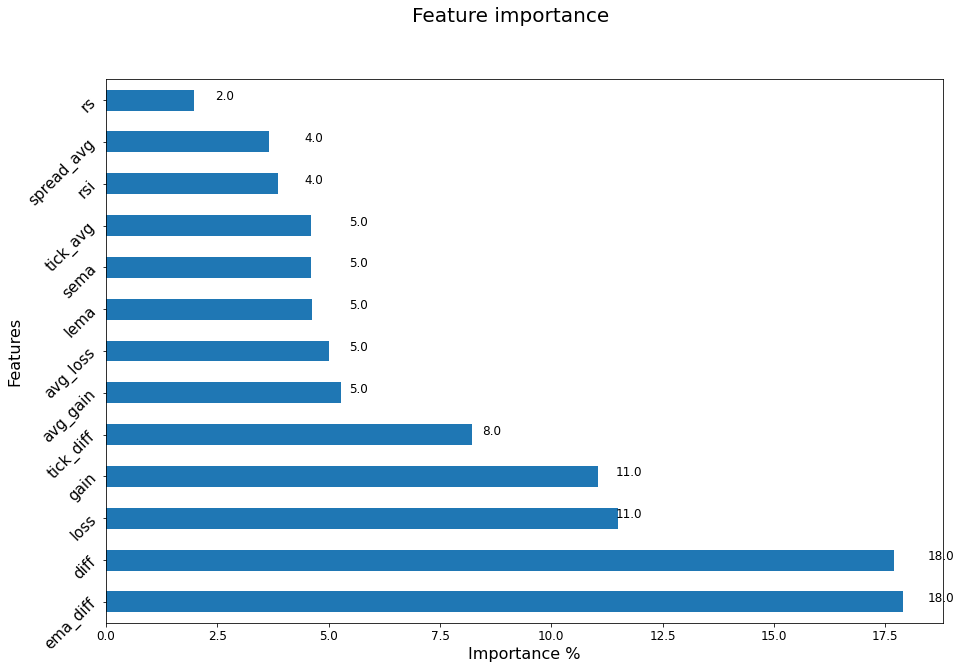

In [9]:
x_cols = df.columns[df.columns != 'direction']
fig = plt.figure()
fig.suptitle('Feature importance', fontsize=20)
plt.xlabel('Importance %', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=15)


feat_importances = pd.Series(clf.feature_importances_ * 100, index=x_cols)
feat_importances.nlargest(24).plot(kind='barh', figsize=(15, 10), rot=45)

for index, value in enumerate(np.round(-np.sort(-clf.feature_importances_ * 100))):
    plt.text(value+0.45, index, str(value), fontsize=12)